# Train a model to learn the shape in an image

Shape categories are: Ellipse, Rectangle, Triangle, Other  
Using Supervised Learning with Tensorflow

Data is received in 3 pickles that contains:
- Train images and labels
- Validation images and labels
- Test images and labels

---
Francois Robert

In [1]:
# Load packages

from IPython.display import display, Image
import imageio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

import os
import sys
from six.moves import cPickle as pickle

In [2]:
import numpy as np

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model   
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image

import datetime
datetime.datetime.now()

datetime.datetime(2022, 1, 9, 18, 28, 27, 267227)

In [3]:
from platform import python_version
print(python_version())

3.8.5


In [4]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [5]:
seed1=128
np.random.seed(seed1)

In [6]:
# GPU Setting
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Define environment variables

In [7]:
BASEDIR = ".."

DATADIR = os.path.join(BASEDIR, "data")
TRAIN_DATADIR   = os.path.join(DATADIR, "train")
VAL_DATADIR     = os.path.join(DATADIR, "val")
TEST_DATADIR    = os.path.join(DATADIR, "test")

PICKLE_DIR     = os.path.join(BASEDIR, 'pickles')
TRAIN_DATAFILE = os.path.join(PICKLE_DIR, 'train.pickle')
VAL_DATAFILE   = os.path.join(PICKLE_DIR, 'val.pickle')
TEST_DATAFILE  = os.path.join(PICKLE_DIR, 'test.pickle')

MODEL_DIR      = os.path.join(BASEDIR, "saved_models")
model_name     = os.path.join(MODEL_DIR, "shapes.model.01") 

image_size     = 70 # Pixel width and height
pixel_depth    = 255.0  # Number of levels per pixel

## Load train, validation and test datasets from Pickles

In [8]:
with open(TRAIN_DATAFILE, 'rb') as f:
    train_dict = pickle.load(f)
with open(VAL_DATAFILE, 'rb') as f:
    val_dict = pickle.load(f)
with open(TEST_DATAFILE, 'rb') as f:
    test_dict = pickle.load(f)

In [9]:
output_labels = [
  'other',     #    0
  'ellipse',   #    1
  'rectangle', #    2
  'triangle']  #    3

In [10]:
## Construct train set
train_X = train_dict['train_data']
train_y = train_dict['train_labels']

In [11]:
## Construct validation set
val_X = val_dict['val_data']
val_y = val_dict['val_labels']

In [12]:
print("train_X shape: ", train_X.shape)
print("train_y shape: ", train_y.shape)

train_X shape:  (21393, 70, 70)
train_y shape:  (21393,)


In [13]:
print("val_X shape: ", val_X.shape)
print("val_y shape: ", val_y.shape)

val_X shape:  (3983, 70, 70)
val_y shape:  (3983,)


In [14]:
# Reshape images to add the channel (height = 70px, width = 70px , channel = 1)
X_train = train_X.reshape(-1,image_size,image_size,1)
X_val   = val_X.reshape(-1,image_size,image_size,1)

In [15]:
# Encode labels to one hot vectors (ex : C -> [0,0,1,0]) using Keras one Hot encoding
Y_train = to_categorical(train_y, num_classes = 4)
Y_val   = to_categorical(val_y, num_classes = 4)

In [16]:
X_train.shape

(21393, 70, 70, 1)

In [17]:
X_val.shape

(3983, 70, 70, 1)

In [18]:
Y_train.shape

(21393, 4)

In [19]:
Y_val.shape

(3983, 4)

In [20]:
def plot_sample(image, axs):
    axs.imshow(image.reshape(image_size, image_size), cmap="gray")

In [21]:
def display_images(X, Y):
    """ This function shows 25 images with their real labels"""

    fig = plt.figure(figsize=(13, 9))
    fig.subplots_adjust(hspace=0.2,wspace=0.2,
                        left=0, right=1, bottom=0, top=1)
    nb_pictures = 25

    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//5 , 5, i+1, xticks=[], yticks=[]) 
        plot_sample(X[i].reshape((image_size, image_size)), ax)
        ax.set_title("{}".format(output_labels[Y[i]]))
    plt.show()

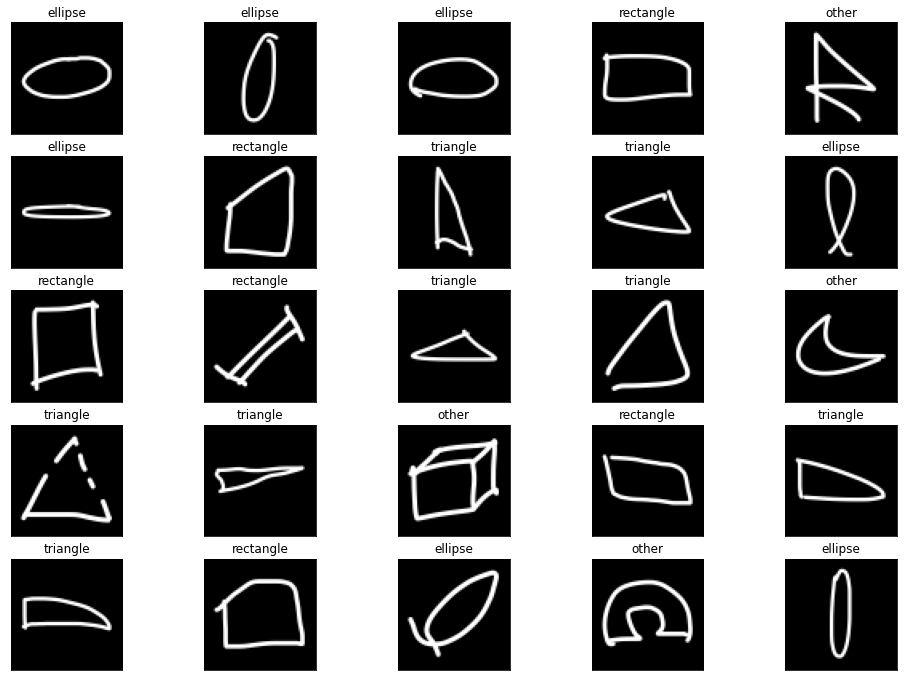

In [22]:
# Show random images from the Train Set
indexes = np.arange(len(train_y))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_images(X_train[first_random_indexes],train_y[first_random_indexes])

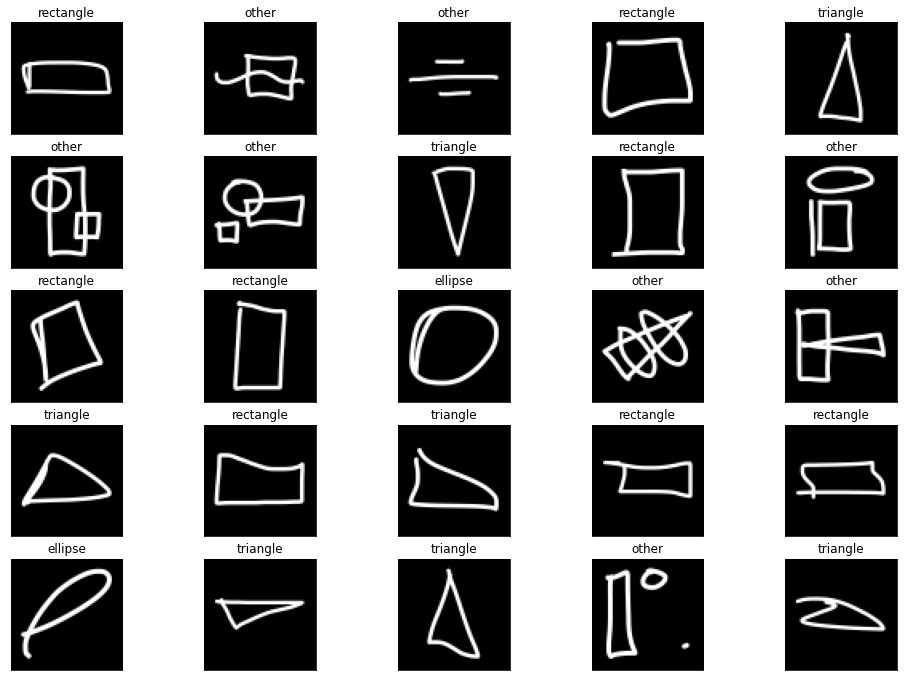

In [23]:
# Show random images from the Validation Set
indexes = np.arange(len(val_y))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_images(X_val[first_random_indexes], val_y[first_random_indexes])

In [24]:
tf.keras.backend.clear_session()

## Define Deep Learning Model

In [25]:
def get_model_cnn():
    # Set the CNN model using Keras functional API
    input_img = Input(shape=(image_size,image_size,1))

    x = Conv2D(32, (5, 5), padding='same')(input_img)  # Conv2D 1
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (5, 5), padding='same')(x)          # Conv2D 2
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3))(x)                          # Conv2D 3
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3))(x)                          # Conv2D 4
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3))(x)                         # Conv2D 5
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3))(x)                         # Conv2D 6
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x) 

    x = Flatten()(x)
    x = Dense(200)(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    output = Dense(4, activation='softmax')(x)

    model = Model(inputs=input_img, outputs=output)
    
    return model

In [26]:
# select a model
model = get_model_cnn()

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70, 70, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 70, 70, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 32)       

## Data augmentation: Full rotation, Flip vert. and Horiz.

### Augmentation helps overfit a lot
A rotation of +/-180 degrees is 360 degrees. With the addition of both flips, this means that even for
something like 300 epochs, the same image will almost never be seen twice. This **helps a lot** for the overfit and allows the model to focus on the essence of each specific shape.

### Data generation 
Note that all the data was generated from within tooling in [Mix on Pix](https://apps.apple.com/us/app/mix-on-pix-text-on-photos/id633281586). So some characteristics are pretty constant like:  
- Stroke width
- Margins
- Color

In [27]:
datagen = ImageDataGenerator(
        rotation_range=180,                  # Randomly rotate images in the range (degrees, 0 to +/-180)
#         zoom_range = [0.98, 1.02],         # Randomly zoom image a bit. Not required
        horizontal_flip=True,                # Randomly horizontal flip 
        vertical_flip=True)                  # Randomly vertical flip

datagen.fit(X_train)

## Define the optimizer

In [28]:
# Adam is generally my best bet for such classifications
optimizer = Adam(lr=2e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)

## Compile the model

In [29]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
# Keras callback to show the result of the best epoch in the model
# Intended to work with ModelCheckpoint callback.
class ShowBestEpochResult(tf.keras.callbacks.Callback):
    def __init__(self, on_param='val_loss', show_params=['val_loss', 'loss'], mode='min'):
        self.on_param    = on_param
        self.show_params = show_params
        self.mode        = mode

    def on_train_begin(self, logs=None):
        # The number of epoch at which the best value is found.
        self.best_epoch = 0

        # The best value found for the on_param.
        self.best = np.Inf
        if self.mode == 'max':
            self.best = np.NINF
            
        # The values on best epoch for each param in show_param.
        self.best_values = {}

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.on_param)
        save_as_best = (self.mode=='min' and current < self.best) or \
                       (self.mode=='max' and current > self.best)

        if save_as_best: 
            self.best = current
            for param in self.show_params:
                self.best_values[param] = logs.get(param)
            self.best_epoch = epoch

    def on_train_end(self, logs=None):
        print(f"BestEpochResult. Epoch: {self.best_epoch+1},", end=" ")

        for param in self.best_values:
            print(f"{param}: {self.best_values[param]:.5f},", end=" ")
        print(" ")

In [31]:
# Lower the learning rate if accuracy stops improving.
#
# Since the 360 rotation and the flips in Data Augmentation put a lot of variability in the Traning data,
# I typically run 200 to 300 epochs and only lower the learning rate very slowly.
# So, the correct setting for patience and factor will be important to reach the best accuracy.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=15,
                                            verbose=1,
                                            factor=0.9,
                                            min_lr=0.000000001)

## Fit the model with data Augmentation

In [32]:
# I like to start a few epoch with a small batch size because:
# - This basically makes the learning rate larger. https://openreview.net/pdf?id=B1Yy1BxCZ#:~:text=Increasing%20the%20batch%20size%20during%20training%20achieves%20similar%20results%20to,twice%20to%20illustrate%20the%20variance.
# - This covers to 0 to 80% of the accuracy curve, cleaning the graphs
epochs = 2 
batch_size = 32
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/2
668/668 [==============================] - 7s 11ms/step - loss: 0.8073 - accuracy: 0.6683 - val_loss: 0.5053 - val_accuracy: 0.8220
Epoch 2/2
668/668 [==============================] - 7s 10ms/step - loss: 0.3962 - accuracy: 0.8555 - val_loss: 0.5652 - val_accuracy: 0.8130


In [33]:
# Save the Best model
h5_path    = model_name + ".h5"
checkpoint = ModelCheckpoint(h5_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

best_epoch_results = ShowBestEpochResult(on_param='val_accuracy', show_params=['val_accuracy', 'accuracy', 'val_loss', 'loss'], mode='max')

callbacks_list = [learning_rate_reduction, checkpoint, best_epoch_results]

epochs = 300 # Training per epoch: CPU (~150s) vs GPU (~6s) per epoch, so 25 times faster!
batch_size = 128
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size, seed=seed1),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=callbacks_list)

Epoch 1/300
166/167 [============================>.] - ETA: 0s - loss: 0.2163 - accuracy: 0.9256
Epoch 00001: val_accuracy improved from -inf to 0.95908, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 7s 40ms/step - loss: 0.2167 - accuracy: 0.9256 - val_loss: 0.1232 - val_accuracy: 0.9591
Epoch 2/300
166/167 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9371
Epoch 00002: val_accuracy improved from 0.95908 to 0.96033, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 6s 38ms/step - loss: 0.1829 - accuracy: 0.9372 - val_loss: 0.1176 - val_accuracy: 0.9603
Epoch 3/300
166/167 [============================>.] - ETA: 0s - loss: 0.1710 - accuracy: 0.9409
Epoch 00003: val_accuracy did not improve from 0.96033
167/167 [==============================] - 6s 38ms/step - loss: 0.1707 - accuracy: 0.9409 - val_loss: 0.1223 - val_accuracy: 0.9568
Epoch 4/300
167/167 [==================

Epoch 29/300
166/167 [============================>.] - ETA: 0s - loss: 0.0869 - accuracy: 0.9710
Epoch 00029: val_accuracy improved from 0.97690 to 0.97866, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 6s 38ms/step - loss: 0.0869 - accuracy: 0.9710 - val_loss: 0.0589 - val_accuracy: 0.9787
Epoch 30/300
167/167 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9735
Epoch 00030: val_accuracy improved from 0.97866 to 0.97941, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 6s 38ms/step - loss: 0.0773 - accuracy: 0.9735 - val_loss: 0.0611 - val_accuracy: 0.9794
Epoch 31/300
167/167 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9701
Epoch 00031: val_accuracy did not improve from 0.97941
167/167 [==============================] - 6s 38ms/step - loss: 0.0859 - accuracy: 0.9701 - val_loss: 0.0661 - val_accuracy: 0.9782
Epoch 32/300
166/167 [===========

Epoch 57/300
167/167 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9820
Epoch 00057: val_accuracy did not improve from 0.99121
167/167 [==============================] - 6s 37ms/step - loss: 0.0542 - accuracy: 0.9820 - val_loss: 0.0342 - val_accuracy: 0.9882
Epoch 58/300
166/167 [============================>.] - ETA: 0s - loss: 0.0527 - accuracy: 0.9834
Epoch 00058: val_accuracy did not improve from 0.99121
167/167 [==============================] - 6s 38ms/step - loss: 0.0527 - accuracy: 0.9834 - val_loss: 0.0550 - val_accuracy: 0.9817
Epoch 59/300
167/167 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9821
Epoch 00059: val_accuracy did not improve from 0.99121
167/167 [==============================] - 6s 38ms/step - loss: 0.0502 - accuracy: 0.9821 - val_loss: 0.0588 - val_accuracy: 0.9804
Epoch 60/300
167/167 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9805
Epoch 00060: val_accuracy did not improve from 

Epoch 85/300
167/167 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9866
Epoch 00085: val_accuracy did not improve from 0.99347
167/167 [==============================] - 6s 38ms/step - loss: 0.0397 - accuracy: 0.9866 - val_loss: 0.0419 - val_accuracy: 0.9869
Epoch 86/300
166/167 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9858
Epoch 00086: val_accuracy did not improve from 0.99347
167/167 [==============================] - 6s 38ms/step - loss: 0.0405 - accuracy: 0.9858 - val_loss: 0.0426 - val_accuracy: 0.9872
Epoch 87/300
166/167 [============================>.] - ETA: 0s - loss: 0.0516 - accuracy: 0.9836
Epoch 00087: val_accuracy did not improve from 0.99347
167/167 [==============================] - 6s 38ms/step - loss: 0.0522 - accuracy: 0.9835 - val_loss: 0.0287 - val_accuracy: 0.9895
Epoch 88/300
166/167 [============================>.] - ETA: 0s - loss: 0.0401 - accuracy: 0.9865
Epoch 00088: val_accuracy did not improve from 

Epoch 114/300
166/167 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.9885
Epoch 00114: val_accuracy did not improve from 0.99347
167/167 [==============================] - 6s 38ms/step - loss: 0.0322 - accuracy: 0.9886 - val_loss: 0.0234 - val_accuracy: 0.9915
Epoch 115/300
167/167 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9897
Epoch 00115: val_accuracy improved from 0.99347 to 0.99397, saving model to ../saved_models/shapes.model.01.h5
167/167 [==============================] - 6s 39ms/step - loss: 0.0325 - accuracy: 0.9897 - val_loss: 0.0180 - val_accuracy: 0.9940
Epoch 116/300
166/167 [============================>.] - ETA: 0s - loss: 0.0343 - accuracy: 0.9891
Epoch 00116: val_accuracy did not improve from 0.99397
167/167 [==============================] - 6s 38ms/step - loss: 0.0343 - accuracy: 0.9890 - val_loss: 0.0213 - val_accuracy: 0.9930
Epoch 117/300
167/167 [==============================] - ETA: 0s - loss: 0.0304 - accu

Epoch 142/300
167/167 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.9906
Epoch 00142: val_accuracy did not improve from 0.99548
167/167 [==============================] - 6s 37ms/step - loss: 0.0277 - accuracy: 0.9906 - val_loss: 0.0321 - val_accuracy: 0.9900
Epoch 143/300
167/167 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.9909
Epoch 00143: val_accuracy did not improve from 0.99548
167/167 [==============================] - 6s 37ms/step - loss: 0.0253 - accuracy: 0.9909 - val_loss: 0.0309 - val_accuracy: 0.9920
Epoch 144/300
167/167 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9915
Epoch 00144: val_accuracy did not improve from 0.99548
167/167 [==============================] - 6s 38ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.0219 - val_accuracy: 0.9927
Epoch 145/300
166/167 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.9903
Epoch 00145: val_accuracy did not improve f

Epoch 170/300
166/167 [============================>.] - ETA: 0s - loss: 0.0215 - accuracy: 0.9921
Epoch 00170: val_accuracy did not improve from 0.99623
167/167 [==============================] - 6s 38ms/step - loss: 0.0215 - accuracy: 0.9921 - val_loss: 0.0250 - val_accuracy: 0.9935
Epoch 171/300
166/167 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9926
Epoch 00171: val_accuracy did not improve from 0.99623
167/167 [==============================] - 6s 38ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 0.0240 - val_accuracy: 0.9927
Epoch 172/300
167/167 [==============================] - ETA: 0s - loss: 0.0195 - accuracy: 0.9933
Epoch 00172: val_accuracy did not improve from 0.99623
167/167 [==============================] - 6s 37ms/step - loss: 0.0195 - accuracy: 0.9933 - val_loss: 0.0219 - val_accuracy: 0.9942
Epoch 173/300
167/167 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9927
Epoch 00173: val_accuracy did not improve f

Epoch 227/300
166/167 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9945
Epoch 00227: val_accuracy did not improve from 0.99623
167/167 [==============================] - 6s 38ms/step - loss: 0.0157 - accuracy: 0.9945 - val_loss: 0.0164 - val_accuracy: 0.9950
Epoch 228/300
166/167 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9952
Epoch 00228: val_accuracy did not improve from 0.99623
167/167 [==============================] - 6s 38ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.0170 - val_accuracy: 0.9955
Epoch 229/300
167/167 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9957
Epoch 00229: val_accuracy did not improve from 0.99623
167/167 [==============================] - 6s 37ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0230 - val_accuracy: 0.9940
Epoch 230/300
166/167 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9951
Epoch 00230: val_accuracy did not improve f

167/167 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9950
Epoch 00283: val_accuracy did not improve from 0.99674
167/167 [==============================] - 6s 37ms/step - loss: 0.0152 - accuracy: 0.9950 - val_loss: 0.0258 - val_accuracy: 0.9927
Epoch 284/300
166/167 [============================>.] - ETA: 0s - loss: 0.0131 - accuracy: 0.9955
Epoch 00284: val_accuracy did not improve from 0.99674
167/167 [==============================] - 6s 38ms/step - loss: 0.0131 - accuracy: 0.9955 - val_loss: 0.0167 - val_accuracy: 0.9947
Epoch 285/300
166/167 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9954
Epoch 00285: val_accuracy did not improve from 0.99674
167/167 [==============================] - 6s 37ms/step - loss: 0.0131 - accuracy: 0.9954 - val_loss: 0.0174 - val_accuracy: 0.9947
Epoch 286/300
167/167 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9958
Epoch 00286: val_accuracy did not improve from 0.99674
16

We see that the best validation accuracy (0.99674) was at epoch 236. Note that we reached 0.99 at epoch 47.


## Plot the loss and accuracy curves for training and validation

In [34]:
def plot_loss(hist,name,plt,RMSE_TF=False):
    '''
    RMSE_TF: if True, then RMSE is plotted with original scale 
    '''
    loss     = hist['loss']
    val_loss = hist['val_loss']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

In [35]:
def plot_accuracy(hist,name,plt,RMSE_TF=False):
    loss     = hist['accuracy']
    val_loss = hist['val_accuracy']
    if RMSE_TF:
        loss = np.sqrt(np.array(loss))*48 
        val_loss = np.sqrt(np.array(val_loss))*48 
        
    plt.plot(loss,"--",linewidth=3,label="train:"+name)
    plt.plot(val_loss,linewidth=3,label="val:"+name)

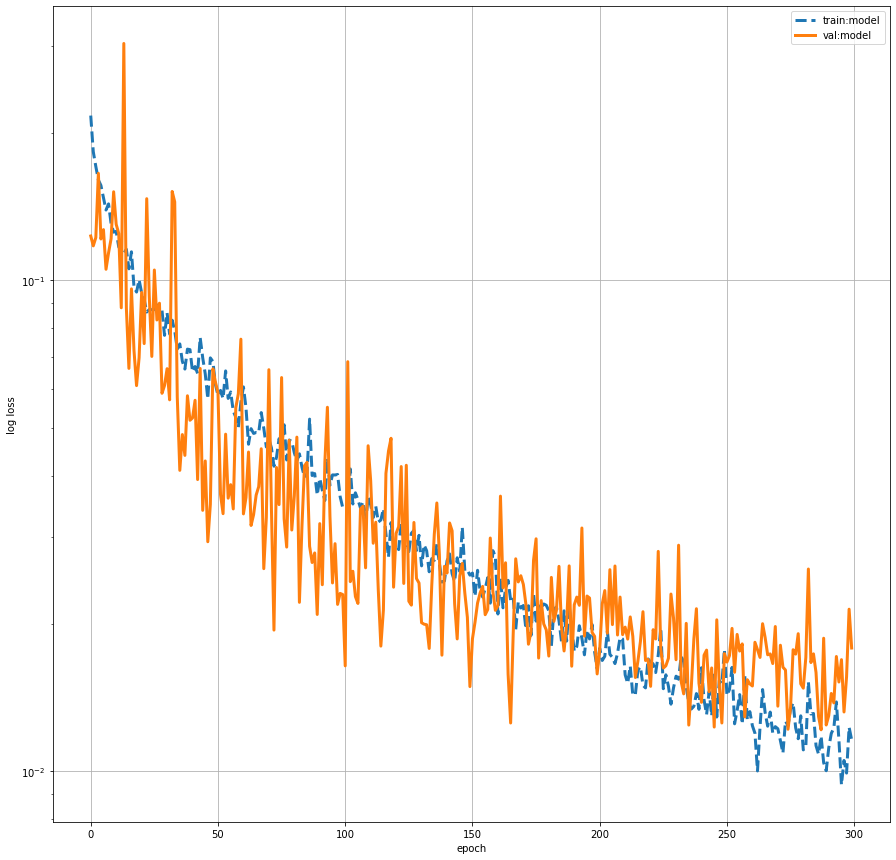

In [36]:
plt.figure(figsize=(15,15))
plot_loss(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")
plt.show()

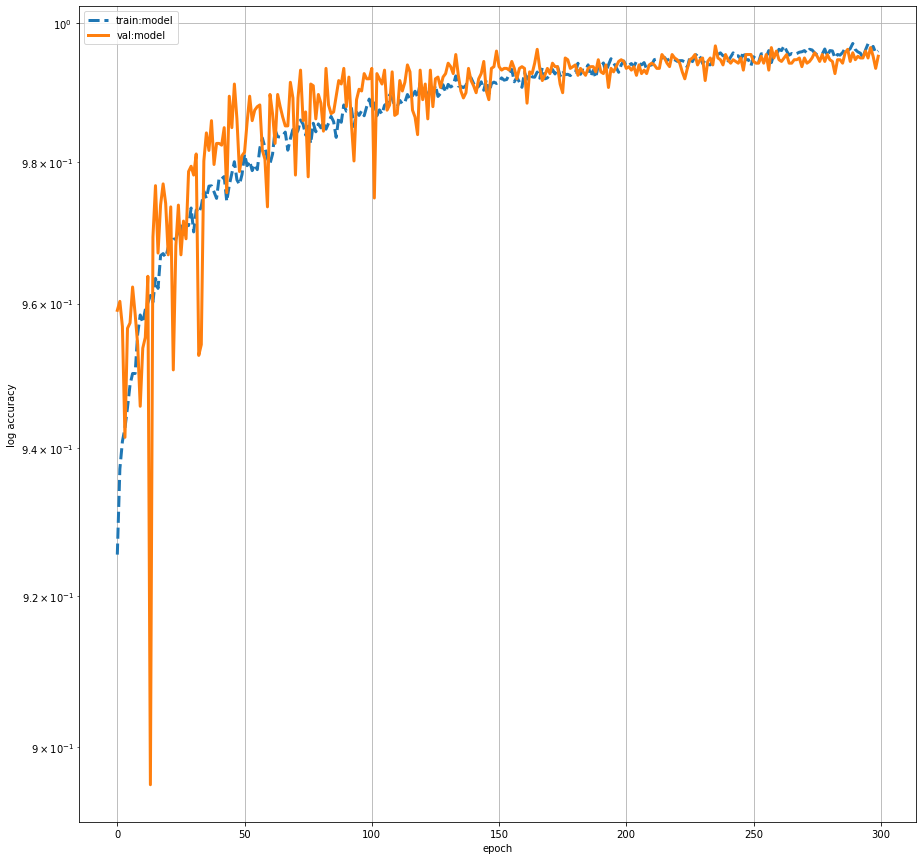

In [37]:
plt.figure(figsize=(15,15))
plot_accuracy(history.history,"model",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log accuracy")
plt.show()

## Delete the existing model + Load the best one

In [38]:
# Delete the existing model
del model

# Load last saved model
model = load_model(model_name + ".h5")

# Look at confusion matrix

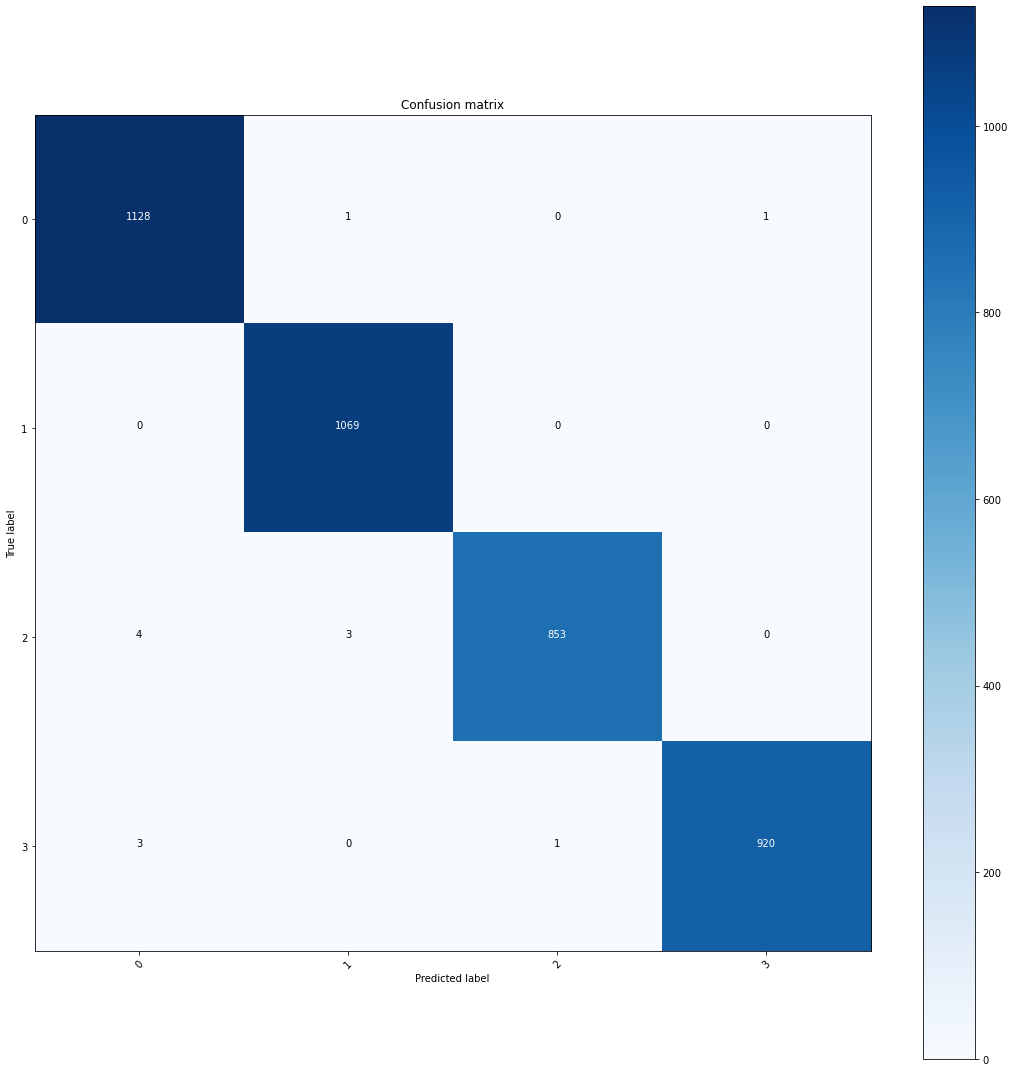

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

In [40]:
# Verify the shapes
print("Y_pred shape: ", Y_pred.shape)                 # Prediction for each image in the validaset set
print("Y_pred_classes shape: ", Y_pred_classes.shape) # Index of the font prediction for each image in the val. set
print("Y_true shape: ", Y_true.shape)                 # Index of the actual font for each image in the val. set
print("confusion_mtx shape: ", confusion_mtx.shape)   # Values in the confusion matrix shown above

Y_pred shape:  (3983, 4)
Y_pred_classes shape:  (3983,)
Y_true shape:  (3983,)
confusion_mtx shape:  (4, 4)


In [41]:
X_val.shape

(3983, 70, 70, 1)

## Analyze the errors

In [42]:
# Errors are difference between predicted labels and true labels. Error[i] is True if this is an error
errors = (Y_pred_classes - Y_true != 0)

# Y_pred_errors: List of Images in the validation set where prediction was bad
X_val_errors = X_val[errors]

# Y_true_errors: Index of the actual font in the validation set where prediction was bad
Y_true_errors = Y_true[errors]

# Y_pred_classes_errors: The list of indexes for font predictions that were bad
Y_pred_classes_errors = Y_pred_classes[errors]

# Y_pred_errors: Prediction for each font in the validation set where prediction was bad
Y_pred_errors = Y_pred[errors]

In [43]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows images with their predicted and real labels"""

    fig = plt.figure(figsize=(13, 15))
    fig.subplots_adjust(hspace=0.13, wspace=0.2, left=0, right=1, bottom=0, top=1)
    nb_pictures = len(errors_index)
    
    for i in range(nb_pictures):
        ax = fig.add_subplot(nb_pictures//3 , 5, i+1, xticks=[], yticks=[]) 
        error = errors_index[i]
        plot_sample((img_errors[error]).reshape((image_size,image_size)), ax)
        ax.set_title("Pred: {}\nTrue : {}".format(output_labels[pred_errors[error]], output_labels[obs_errors[error]]))
    plt.show() 

## Show the biggest errors

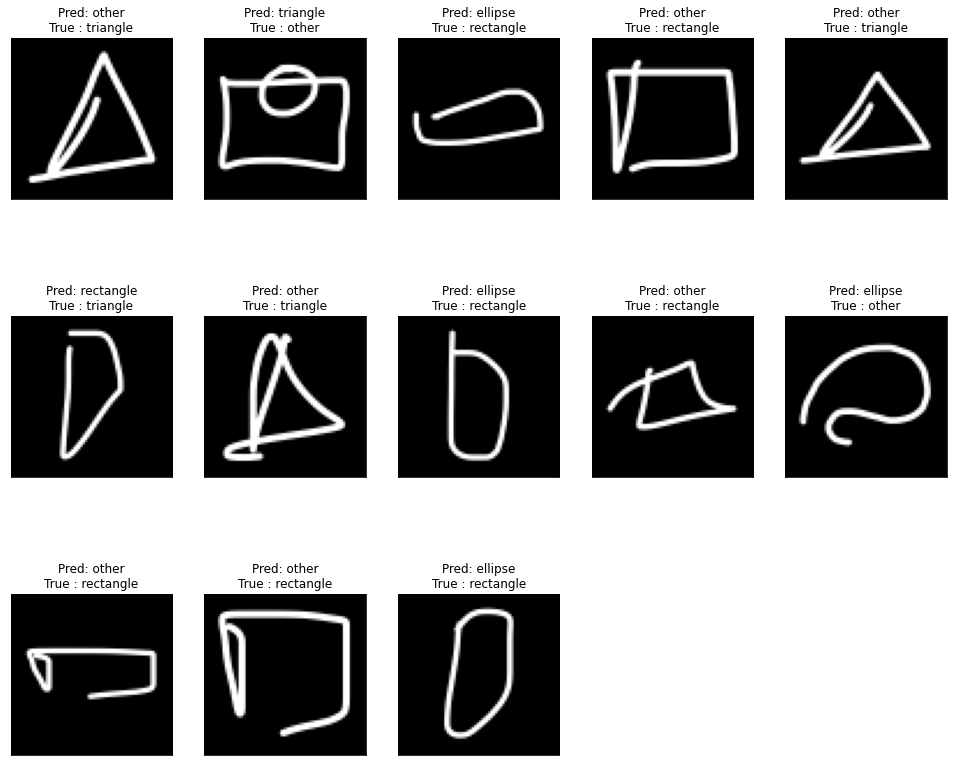

In [44]:
# Probabilities of the wrong predicted numbers. Prob for the bad choice
Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)

# Predicted probabilities of the true values in the error set. Prob for the good choice
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top errors 
most_important_errors = sorted_delta_errors[-15:]

# Show the top errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

### Conclusion from Confusion matrix and Biggest errors
We see that most errors relate to the differentiation between **Other** and actual shape. 
This is specially true since we allow some incomplete shapes (like some **3 sides rectangles**) or some extra 
strokes (like a triangle with one side being drawn **twice**) to be valid shapes.  
This is useful when the goal is to determine what the intent of the user drawing shapes. This makes the problem **more difficult**, but also **more interesting**.

## Predict for the test set

In [45]:
## Prepare test set
test_X = test_dict['test_data']
test_y = test_dict['test_labels']
print("test_X shape: ", test_X.shape)
print("test_y shape: ", test_y.shape)

X_test    = test_X.reshape(-1,image_size,image_size,1)
Y_test    = to_categorical(test_y, num_classes = 4)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

test_X shape:  (1923, 70, 70)
test_y shape:  (1923,)
X_test shape:  (1923, 70, 70, 1)
Y_test shape:  (1923, 4)


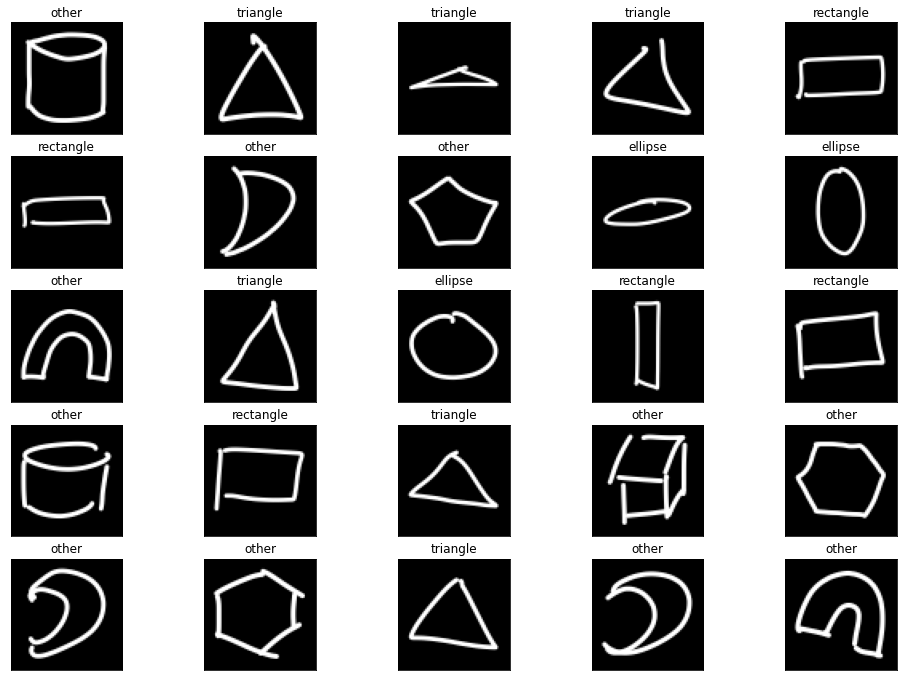

In [46]:
# Show random images from the test Set
indexes = np.arange(len(test_y))
np.random.shuffle(indexes)
first_random_indexes = indexes[:25]

display_images(X_test[first_random_indexes], test_y[first_random_indexes])

## Show accuracy for the test set

In [47]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print("test_acc: ", test_acc)

61/61 [==============================] - 0s 3ms/step - loss: 5.2748e-04 - accuracy: 1.0000
test_acc:  1.0


In [48]:
# All done
datetime.datetime.now()

datetime.datetime(2022, 1, 9, 19, 0, 50, 131027)

# Conclusions
Accuracy is pretty good and was definitively useful in [Mix on Pix](https://apps.apple.com/us/app/mix-on-pix-text-on-photos/id633281586).

## TensorFlow Lite Notes
When creating a TensorFlow Lite model with quantization, accuracy can be a tiny bit lower, but the model size is 25% of the original.